In [ ]:
# Copyright 2025 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Evaluate your ADK agent using Vertex AI Gen AI Evaluation service

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/gemini/evaluation/evaluating_adk_agent.ipynb">
      <img width="32px" src="https://www.gstatic.com/pantheon/images/bigquery/welcome_page/colab-logo.svg" alt="Google Colaboratory logo"><br> Open in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fgenerative-ai%2Fmain%2Fgemini%2Fevaluation%2Fevaluating_adk_agent.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo"><br> Open in Colab Enterprise
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/main/gemini/evaluation/evaluating_adk_agent.ipynb">
      <img src="https://www.gstatic.com/images/branding/gcpiconscolors/vertexai/v1/32px.svg" alt="Vertex AI logo"><br> Open in Vertex AI Workbench
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/evaluation/evaluating_adk_agent.ipynb">
      <img width="32px" src="https://www.svgrepo.com/download/217753/github.svg" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
</table>

<div style="clear: both;"></div>

<b>Share to:</b>

<a href="https://www.linkedin.com/sharing/share-offsite/?url=https%3A//github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/evaluation/evaluating_adk_agent.ipynb" target="_blank">
  <img width="20px" src="https://upload.wikimedia.org/wikipedia/commons/8/81/LinkedIn_icon.svg" alt="LinkedIn logo">
</a>

<a href="https://bsky.app/intent/compose?text=https%3A//github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/evaluation/evaluating_adk_agent.ipynb" target="_blank">
  <img width="20px" src="https://upload.wikimedia.org/wikipedia/commons/7/7a/Bluesky_Logo.svg" alt="Bluesky logo">
</a>

<a href="https://twitter.com/intent/tweet?url=https%3A//github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/evaluation/evaluating_adk_agent.ipynb" target="_blank">
  <img width="20px" src="https://upload.wikimedia.org/wikipedia/commons/5/5a/X_icon_2.svg" alt="X logo">
</a>

<a href="https://reddit.com/submit?url=https%3A//github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/evaluation/evaluating_adk_agent.ipynb" target="_blank">
  <img width="20px" src="https://redditinc.com/hubfs/Reddit%20Inc/Brand/Reddit_Logo.png" alt="Reddit logo">
</a>

<a href="https://www.facebook.com/sharer/sharer.php?u=https%3A//github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/evaluation/evaluating_adk_agent.ipynb" target="_blank">
  <img width="20px" src="https://upload.wikimedia.org/wikipedia/commons/5/51/Facebook_f_logo_%282019%29.svg" alt="Facebook logo">
</a>

| Author(s) |
| --- |
| [Ivan Nardini](https://github.com/inardini) |

## Overview

Agent Development Kit (ADK in short) is a flexible and modular open source framework for developing and deploying AI agents. While ADK has its own evaluation module, using Vertex AI Gen AI Evaluation provides a toolkit of quality controlled and explainable methods and metrics to evaluate any generative model or application, including agents, and benchmark the evaluation results against your own judgment, using your own evaluation criteria.

This tutorial shows how to evaluate an ADK agent using Vertex AI Gen AI Evaluation for agent evaluation.

The steps performed include:

* Build local agent using ADK
* Prepare Agent Evaluation dataset
* Single tool usage evaluation
* Trajectory evaluation
* Response evaluation

## Get started

### Install Google Gen AI SDK and other required packages


In [1]:
%pip install --upgrade --quiet \
  "google-adk==0.5.0" \
  "google-cloud-aiplatform[evaluation]" \
  "deprecated>=1.2.14"


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Authenticate your notebook environment (Colab only)

If you're running this notebook on Google Colab, run the cell below to authenticate your environment.

In [ ]:
import sys

if "google.colab" in sys.modules:
    from google.colab import auth

    auth.authenticate_user()

### Set Google Cloud project information

To get started using Vertex AI, you must have an existing Google Cloud project and [enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com).

Learn more about [setting up a project and a development environment](https://cloud.google.com/vertex-ai/docs/start/cloud-environment).

In [1]:
# Use the environment variable if the user doesn't provide Project ID.
import os

import vertexai

PROJECT_ID = "[your-project-id]"  # @param {type: "string", placeholder: "[your-project-id]", isTemplate: true}
if not PROJECT_ID or PROJECT_ID == "[your-project-id]":
    PROJECT_ID = str(os.environ.get("GOOGLE_CLOUD_PROJECT"))

LOCATION = os.environ.get("GOOGLE_CLOUD_REGION", "us-central1")

BUCKET_NAME = PROJECT_ID # "[your-bucket-name]"  # @param {type: "string", placeholder: "[your-bucket-name]", isTemplate: true}
BUCKET_URI = f"gs://{BUCKET_NAME}"

!gsutil mb -l {LOCATION} {BUCKET_URI}

os.environ["GOOGLE_CLOUD_PROJECT"] = PROJECT_ID
os.environ["GOOGLE_CLOUD_LOCATION"] = LOCATION
os.environ["GOOGLE_GENAI_USE_VERTEXAI"] = "True"

EXPERIMENT_NAME = "evaluate-adk-agent"  # @param {type:"string"}

vertexai.init(project=PROJECT_ID, location=LOCATION, experiment=EXPERIMENT_NAME)

Creating gs://qwiklabs-gcp-00-1c1e83b66667/...


In [4]:
PROJECT_ID, BUCKET_NAME

('qwiklabs-gcp-00-1c1e83b66667', 'qwiklabs-gcp-00-1c1e83b66667')

In [2]:
os.environ

environ{'SHELL': '/bin/bash',
        'CONDA_EXE': '/opt/conda/bin/conda',
        '_CE_M': '',
        'VERTEX_PRODUCT': 'WORKBENCH_INSTANCE',
        'GRPC_FORK_SUPPORT_ENABLED': '0',
        'DL_ANACONDA_HOME': '/opt/conda',
        'FRAMEWORK_FILE_PATH': '/opt/deeplearning/metadata/framework',
        'GOOGLE_CLOUD_PROJECT': 'qwiklabs-gcp-00-1c1e83b66667',
        'POST_STARTUP_SCRIPT_PATH': '/opt/c2d/post_start.sh',
        'DL_PATH_DEPS': '/opt/deeplearning/deps',
        'DL_BIN_PATH': '/opt/deeplearning/bin',
        'XML_CATALOG_FILES': 'file:///opt/conda/etc/xml/catalog file:///etc/xml/catalog',
        'KERNEL_LAUNCH_TIMEOUT': '598',
        'BINARIES_PATH': '/opt/deeplearning/binaries',
        'PWD': '/home/jupyter',
        'LOGNAME': 'jupyter',
        'CONDA_PREFIX': '/opt/conda',
        'JPY_SESSION_NAME': '/home/jupyter/evaluating_adk_agent-v1.1.0.ipynb',
        'TENSORBOARD_PROXY_URL': '/proxy/%PORT%/',
        'GOOGLE_CLOUD_REGION': 'us-central1',
        'PACKAGE

## Import libraries

Import tutorial libraries.

In [5]:
import json

# General
import random
import string
from typing import Any

from IPython.display import HTML, Markdown, display
from google.adk.agents import Agent

# Build agent with adk
from google.adk.events import Event
from google.adk.runners import Runner
from google.adk.sessions import InMemorySessionService

# Evaluate agent
from google.cloud import aiplatform
from google.genai import types
import pandas as pd
import plotly.graph_objects as go
from vertexai.preview.evaluation import EvalTask
from vertexai.preview.evaluation.metrics import (
    PointwiseMetric,
    PointwiseMetricPromptTemplate,
    TrajectorySingleToolUse,
)

## Define helper functions

Initiate a set of helper functions to print tutorial results.

In [6]:
def get_id(length: int = 8) -> str:
    """Generate a uuid of a specified length (default=8)."""
    return "".join(random.choices(string.ascii_lowercase + string.digits, k=length))


def parse_adk_output_to_dictionary(events: list[Event]) -> dict[str, Any]:
    """
    Parse ADK event output into a structured dictionary format,
    with the predicted trajectory dumped as a JSON string.

    """

    final_response = ""
    predicted_trajectory_list = []

    for event in events:
        # Ensure content and parts exist before accessing them
        if not event.content or not event.content.parts:
            continue

        # Iterate through ALL parts in the event's content
        for part in event.content.parts:
            if part.function_call:
                tool_info = {
                    "tool_name": part.function_call.name,
                    "tool_input": dict(part.function_call.args),
                }
                # Ensure we don't add duplicates if the same call appears somehow
                if tool_info not in predicted_trajectory_list:
                    predicted_trajectory_list.append(tool_info)

            # The final text response is usually in the last event from the model
            if event.content.role == "model" and part.text:
                # Overwrite response; the last text response found is likely the final one
                final_response = part.text.strip()

    # Dump the collected trajectory list into a JSON string
    final_output = {
        "response": str(final_response),
        "predicted_trajectory": json.dumps(predicted_trajectory_list),
    }

    return final_output


def format_output_as_markdown(output: dict) -> str:
    """Convert the output dictionary to a formatted markdown string."""
    markdown = "### AI Response\n"
    markdown += f"{output['response']}\n\n"

    if output["predicted_trajectory"]:
        output["predicted_trajectory"] = json.loads(output["predicted_trajectory"])
        markdown += "### Function Calls\n"
        for call in output["predicted_trajectory"]:
            markdown += f"- **Function**: `{call['tool_name']}`\n"
            markdown += "  - **Arguments**:\n"
            for key, value in call["tool_input"].items():
                markdown += f"    - `{key}`: `{value}`\n"

    return markdown


def display_eval_report(eval_result: pd.DataFrame) -> None:
    """Display the evaluation results."""
    metrics_df = pd.DataFrame.from_dict(eval_result.summary_metrics, orient="index").T
    display(Markdown("### Summary Metrics"))
    display(metrics_df)

    display(Markdown("### Row-wise Metrics"))
    display(eval_result.metrics_table)


def display_drilldown(row: pd.Series) -> None:
    """Displays a drill-down view for trajectory data within a row."""

    style = "white-space: pre-wrap; width: 800px; overflow-x: auto;"

    if not (
        isinstance(row["predicted_trajectory"], list)
        and isinstance(row["reference_trajectory"], list)
    ):
        return

    for predicted_trajectory, reference_trajectory in zip(
        row["predicted_trajectory"], row["reference_trajectory"]
    ):
        display(
            HTML(
                f"<h3>Tool Names:</h3><div style='{style}'>{predicted_trajectory['tool_name'], reference_trajectory['tool_name']}</div>"
            )
        )

        if not (
            isinstance(predicted_trajectory.get("tool_input"), dict)
            and isinstance(reference_trajectory.get("tool_input"), dict)
        ):
            continue

        for tool_input_key in predicted_trajectory["tool_input"]:
            print("Tool Input Key: ", tool_input_key)

            if tool_input_key in reference_trajectory["tool_input"]:
                print(
                    "Tool Values: ",
                    predicted_trajectory["tool_input"][tool_input_key],
                    reference_trajectory["tool_input"][tool_input_key],
                )
            else:
                print(
                    "Tool Values: ",
                    predicted_trajectory["tool_input"][tool_input_key],
                    "N/A",
                )
        print("\n")
    display(HTML("<hr>"))


def display_dataframe_rows(
    df: pd.DataFrame,
    columns: list[str] | None = None,
    num_rows: int = 3,
    display_drilldown: bool = False,
) -> None:
    """Displays a subset of rows from a DataFrame, optionally including a drill-down view."""

    if columns:
        df = df[columns]

    base_style = "font-family: monospace; font-size: 14px; white-space: pre-wrap; width: auto; overflow-x: auto;"
    header_style = base_style + "font-weight: bold;"

    for _, row in df.head(num_rows).iterrows():
        for column in df.columns:
            display(
                HTML(
                    f"<span style='{header_style}'>{column.replace('_', ' ').title()}: </span>"
                )
            )
            display(HTML(f"<span style='{base_style}'>{row[column]}</span><br>"))

        display(HTML("<hr>"))

        if (
            display_drilldown
            and "predicted_trajectory" in df.columns
            and "reference_trajectory" in df.columns
        ):
            display_drilldown(row)


def plot_bar_plot(
    eval_result: pd.DataFrame, title: str, metrics: list[str] = None
) -> None:
    fig = go.Figure()
    data = []

    summary_metrics = eval_result.summary_metrics
    if metrics:
        summary_metrics = {
            k: summary_metrics[k]
            for k, v in summary_metrics.items()
            if any(selected_metric in k for selected_metric in metrics)
        }

    data.append(
        go.Bar(
            x=list(summary_metrics.keys()),
            y=list(summary_metrics.values()),
            name=title,
        )
    )

    fig = go.Figure(data=data)

    # Change the bar mode
    fig.update_layout(barmode="group")
    fig.show()


def display_radar_plot(eval_results, title: str, metrics=None):
    """Plot the radar plot."""
    fig = go.Figure()
    summary_metrics = eval_results.summary_metrics
    if metrics:
        summary_metrics = {
            k: summary_metrics[k]
            for k, v in summary_metrics.items()
            if any(selected_metric in k for selected_metric in metrics)
        }

    min_val = min(summary_metrics.values())
    max_val = max(summary_metrics.values())

    fig.add_trace(
        go.Scatterpolar(
            r=list(summary_metrics.values()),
            theta=list(summary_metrics.keys()),
            fill="toself",
            name=title,
        )
    )
    fig.update_layout(
        title=title,
        polar=dict(radialaxis=dict(visible=True, range=[min_val, max_val])),
        showlegend=True,
    )
    fig.show()

In [7]:
# explore
get_id(), get_id(), get_id()

('g9b9tcq6', 'rs73rgdv', 'zh6nkpvk')

# Task 2 Build, Run ADK Agent

## Build ADK agent

Build your application using ADK, including the Gemini model and custom tools that you define.

### Set tools

To start, set the tools that a customer support agent needs to do their job.

In [8]:
# 2 fns as tools
def get_product_details(product_name: str):
    """Gathers basic details about a product."""
    details = {
        "smartphone": "A cutting-edge smartphone with advanced camera features and lightning-fast processing.",
        "usb charger": "A super fast and light usb charger",
        "shoes": "High-performance running shoes designed for comfort, support, and speed.",
        "headphones": "Wireless headphones with advanced noise cancellation technology for immersive audio.",
        "speaker": "A voice-controlled smart speaker that plays music, sets alarms, and controls smart home devices.",
    }
    return details.get(product_name, "Product details not found.")


def get_product_price(product_name: str):
    """Gathers price about a product."""
    details = {
        "smartphone": 500,
        "usb charger": 10,
        "shoes": 100,
        "headphones": 50,
        "speaker": 80,
    }
    return details.get(product_name, "Product price not found.")

### Set the model

Choose which Gemini AI model your agent will use. If you're curious about Gemini and its different capabilities, take a look at [the official documentation](https://cloud.google.com/vertex-ai/generative-ai/docs/learn/models) for more details.

In [9]:
model = "gemini-2.0-flash"

### Assemble the agent

The Vertex AI Gen AI Evaluation works directly with 'Queryable' agents, and also lets you add your own custom functions with a specific structure (signature).

In this case, you assemble the agent using a custom function. The function triggers the agent for a given input and parses the agent outcome to extract the response and called tools.

In [15]:
def agent_parsed_outcome(query):

    app_name = "product_research_app"
    user_id = "user_one"
    session_id = "session_one"

    product_research_agent = Agent(
        name="ProductResearchAgent",
        model=model,
        description="An agent that performs product research.",
        instruction=f"""
        Analyze this user request: '{query}'.
        If the request is about price, use get_product_price tool.
        Otherwise, use get_product_details tool to get product information.
        """,
        
        # in the system instruction above, add
        #   scenario(s) when u use each tool
        
        # add those 2 tool fns below
        tools=[get_product_details, get_product_price],
    )

    session_service = InMemorySessionService()
    _ = session_service.create_session(
        app_name=app_name, user_id=user_id, session_id=session_id
    )
    runner = Runner(
        agent=product_research_agent, app_name=app_name, session_service=session_service
    )

    content = types.Content(role="user", parts=[types.Part(text=query)])
    events = list(
        runner.run(user_id=user_id, session_id=session_id, new_message=content)
    )
    return parse_adk_output_to_dictionary(events)

In [12]:
InMemorySessionService()

In [13]:
InMemorySessionService().__dict__

{'sessions': {}, 'user_state': {}, 'app_state': {}}

### Test the agent

Query your agent.

In [27]:
# query 1
response = agent_parsed_outcome(query="Get product details for shoes")
display(Markdown(format_output_as_markdown(response)))

### AI Response
OK. I have gathered product details for shoes. High-performance running shoes designed for comfort, support, and speed.

### Function Calls
- **Function**: `get_product_details`
  - **Arguments**:
    - `product_name`: `shoes`


In [18]:
InMemorySessionService().list_sessions

<bound method InMemorySessionService.list_sessions of <google.adk.sessions.in_memory_session_service.InMemorySessionService object at 0x7fcc89896860>>

In [25]:
InMemorySessionService().list_sessions.__dict__

{'__override__': True}

In [23]:
app_name = "product_research_app"
user_id = "user_one"
session_id = "session_one"
session1 = InMemorySessionService().get_session(app_name=app_name, 
                                                user_id=user_id, 
                                                session_id=session_id)
session1

In [24]:
session1

In [28]:
InMemorySessionService().sessions

{}

In [29]:
# query 2
response = agent_parsed_outcome(query="Get product price for shoes")
display(Markdown(format_output_as_markdown(response)))

### AI Response
The price for shoes is 100.

### Function Calls
- **Function**: `get_product_price`
  - **Arguments**:
    - `product_name`: `shoes`


## Evaluating a ADK agent with Vertex AI Gen AI Evaluation

When working with AI agents, it's important to keep track of their performance and how well they're working. You can look at this in two main ways: **monitoring** and **observability**.

Monitoring focuses on how well your agent is performing specific tasks:

* **Single Tool Selection**: Is the agent choosing the right tools for the job?

* **Multiple Tool Selection (or Trajectory)**: Is the agent making logical choices in the order it uses tools?

* **Response generation**: Is the agent's output good, and does it make sense based on the tools it used?

Observability is about understanding the overall health of the agent:

* **Latency**: How long does it take the agent to respond?

* **Failure Rate**: How often does the agent fail to produce a response?

Vertex AI Gen AI Evaluation service helps you to assess all of these aspects both while you are prototyping the agent or after you deploy it in production. It provides [pre-built evaluation criteria and metrics](https://cloud.google.com/vertex-ai/generative-ai/docs/models/determine-eval) so you can see exactly how your agents are doing and identify areas for improvement.

### Prepare Agent Evaluation dataset

To evaluate your AI agent using the Vertex AI Gen AI Evaluation service, you need a specific dataset depending on what aspects of your agent you want to evaluate. 

This dataset should include the prompts given to the agent. It can also contain the ideal or expected response (ground truth) and the intended sequence of tool calls the agent should take (reference trajectory) representing the sequence of tools you expect agent calls for each given prompt.

> Optionally, you can provide both generated responses and predicted trajectory (**Bring-Your-Own-Dataset scenario**).

Below you have an example of dataset you might have with a customer support agent with user prompt and the reference trajectory.

In [30]:
eval_data = {
    "prompt": [
        "Get price for smartphone",
        "Get product details and price for headphones",
        "Get details for usb charger",
        "Get product details and price for shoes",
        "Get product details for speaker?",
    ],
    "reference_trajectory": [
        [
            {
                "tool_name": "get_product_price",
                "tool_input": {"product_name": "smartphone"},
            }
        ],
        [
            {
                "tool_name": "get_product_details",
                "tool_input": {"product_name": "headphones"},
            },
            {
                "tool_name": "get_product_price",
                "tool_input": {"product_name": "headphones"},
            },
        ],
        [
            {
                "tool_name": "get_product_details",
                "tool_input": {"product_name": "usb charger"},
            }
        ],
        [
            {
                "tool_name": "get_product_details",
                "tool_input": {"product_name": "shoes"},
            },
            {"tool_name": "get_product_price", 
             "tool_input": {"product_name": "shoes"}},
        ],
        [
            {
                "tool_name": "get_product_details",
                "tool_input": {"product_name": "speaker"},
            }
        ],
    ],
}

eval_sample_dataset = pd.DataFrame(eval_data)

Print some samples from the dataset.

In [31]:
display_dataframe_rows(eval_sample_dataset, num_rows=3)

# Task 3. Evaluate an ADK Agent with Vertex AI Gen AI Evaluation


### Single tool usage evaluation

After you've set your AI agent and the evaluation dataset, you start evaluating if the agent is choosing the correct single tool for a given task.


#### Set single tool usage metrics

The `trajectory_single_tool_use` metric in Vertex AI Gen AI Evaluation gives you a quick way to evaluate whether your agent is using the tool you expect it to use, regardless of any specific tool order. It's a basic but useful way to start evaluating if the right tool was used at some point during the agent's process.

To use the `trajectory_single_tool_use` metric, you need to set what tool should have been used for a particular user's request. For example, if a user asks to "send an email", you might expect the agent to use an "send_email" tool, and you'd specify that tool's name when using this metric.


In [32]:
single_tool_usage_metrics = [TrajectorySingleToolUse(tool_name="get_product_price")]

In [33]:
single_tool_usage_metrics

In [35]:
single_tool_usage_metrics[0].__dict__

{'_tool_name': 'get_product_price', '_metric': 'trajectory_single_tool_use'}

#### Run an evaluation task

To run the evaluation, you initiate an `EvalTask` using the pre-defined dataset (`eval_sample_dataset`) and metrics (`single_tool_usage_metrics` in this case) within an experiment. Then, you run the evaluation using agent_parsed_outcome function and assigns a unique identifier to this specific evaluation run, storing and visualizing the evaluation results.


In [36]:
EXPERIMENT_RUN = f"single-metric-eval-{get_id()}"

single_tool_call_eval_task = EvalTask(
    dataset=eval_sample_dataset,
    metrics=single_tool_usage_metrics,
    experiment=EXPERIMENT_NAME,
    output_uri_prefix=BUCKET_URI + "/single-metric-eval",
)



single_tool_call_eval_result = single_tool_call_eval_task.evaluate(
    runnable=agent_parsed_outcome, 
    experiment_run_name=EXPERIMENT_RUN
)

display_eval_report(single_tool_call_eval_result)

INFO:vertexai.preview.evaluation.eval_task:Logging Eval experiment evaluation metadata: {'output_file': 'gs://qwiklabs-gcp-00-1c1e83b66667/single-metric-eval/eval_results_2025-10-27-06-09-33-ad431.csv'}
100%|██████████| 5/5 [00:01<00:00,  3.51it/s]
INFO:vertexai.preview.evaluation._evaluation:All 5 responses are successfully generated from the runnable.
INFO:vertexai.preview.evaluation._evaluation:Computing metrics with a total of 5 Vertex Gen AI Evaluation Service API requests.
100%|██████████| 5/5 [00:00<00:00, 11.06it/s]
INFO:vertexai.preview.evaluation._evaluation:All 5 metric requests are successfully computed.
INFO:vertexai.preview.evaluation._evaluation:Evaluation Took:0.4684789899997668 seconds


### Summary Metrics

,row_count,trajectory_single_tool_use/mean,trajectory_single_tool_use/std,latency_in_seconds/mean,latency_in_seconds/std,failure/mean,failure/std
0,5.0,0.6,0.547723,1.134585,0.226322,0.0,0.0


### Row-wise Metrics

,prompt,reference_trajectory,response,latency_in_seconds,failure,predicted_trajectory,trajectory_single_tool_use/score
0,Get price for smartphone,"[{'tool_name': 'get_product_price', 'tool_inpu...",The price for smartphone is 500.,0.831248,0,"[{""tool_name"": ""get_product_price"", ""tool_inpu...",1.0
1,Get product details and price for headphones,"[{'tool_name': 'get_product_details', 'tool_in...",OK. I found that the headphones are wireless w...,1.286816,0,"[{""tool_name"": ""get_product_details"", ""tool_in...",1.0
2,Get details for usb charger,"[{'tool_name': 'get_product_details', 'tool_in...",OK. I have the details for the usb charger. It...,1.005017,0,"[{""tool_name"": ""get_product_details"", ""tool_in...",0.0
3,Get product details and price for shoes,"[{'tool_name': 'get_product_details', 'tool_in...",OK. The price for shoes is $100. The shoes are...,1.404386,0,"[{""tool_name"": ""get_product_price"", ""tool_inpu...",1.0
4,Get product details for speaker?,"[{'tool_name': 'get_product_details', 'tool_in...",OK. I have gathered product details for speake...,1.145459,0,"[{""tool_name"": ""get_product_details"", ""tool_in...",0.0


In [42]:
single_tool_call_eval_task

In [44]:
single_tool_call_eval_task.__dict__

{'_dataset':                                          prompt  \
 0                      Get price for smartphone   
 1  Get product details and price for headphones   
 2                   Get details for usb charger   
 3       Get product details and price for shoes   
 4              Get product details for speaker?   
 
                                 reference_trajectory  
 0  [{'tool_name': 'get_product_price', 'tool_inpu...  
 1  [{'tool_name': 'get_product_details', 'tool_in...  
 2  [{'tool_name': 'get_product_details', 'tool_in...  
 3  [{'tool_name': 'get_product_details', 'tool_in...  
 4  [{'tool_name': 'get_product_details', 'tool_in...  ,
 '_metrics': [<vertexai.preview.evaluation.metrics._trajectory_single_tool_use.TrajectorySingleToolUse at 0x7fcc88fa13c0>],
 '_experiment': 'evaluate-adk-agent',
 '_metric_column_mapping': {'prompt': 'prompt',
  'reference_trajectory': 'reference_trajectory'},
 'output_uri_prefix': 'gs://qwiklabs-gcp-00-1c1e83b66667/single-metric-eval'

In [43]:
single_tool_call_eval_result

EvalResult(summary_metrics={'row_count': 5, 'trajectory_single_tool_use/mean': 0.6, 'trajectory_single_tool_use/std': 0.5477225575051662, 'latency_in_seconds/mean': 1.1345853881999575, 'latency_in_seconds/std': 0.22632170752538816, 'failure/mean': 0.0, 'failure/std': 0.0}, metrics_table=                                         prompt  \
0                      Get price for smartphone   
1  Get product details and price for headphones   
2                   Get details for usb charger   
3       Get product details and price for shoes   
4              Get product details for speaker?   

                                reference_trajectory  \
0  [{'tool_name': 'get_product_price', 'tool_inpu...   
1  [{'tool_name': 'get_product_details', 'tool_in...   
2  [{'tool_name': 'get_product_details', 'tool_in...   
3  [{'tool_name': 'get_product_details', 'tool_in...   
4  [{'tool_name': 'get_product_details', 'tool_in...   

                                            response latency_in_seco

#### Visualize evaluation results

Use some helper functions to visualize a sample of evaluation result.

In [40]:
display_dataframe_rows(single_tool_call_eval_result.metrics_table, num_rows=5)

**Student Notes 2025.10.27**
- It seems that the TrajectorySingleToolUse score is 1 if the 'get_product_price' tool is ever used in the agent's process flow, and 0 otherwise
- If an agent's process flow in correct by not invoking the 'get_product_price' tool when it only needs to invoke 'get_product_details'
  - This is the expected agent's behavior -> For a layperson, I would have thought that the agent would get a score of '1'
  - However, it seems that Google Agent Development Kit (ADK) does not factor such a nuance in its scoring system, and instead gives a score of 0

# Task 4. Perform Trajectory Evaluation


### Trajectory Evaluation

After evaluating the agent's ability to select the single most appropriate tool for a given task, you generalize the evaluation by analyzing the tool sequence choices with respect to the user input (trajectory). This assesses whether the agent not only chooses the right tools but also utilizes them in a rational and effective order.

#### Set trajectory metrics

To evaluate agent's trajectory, Vertex AI Gen AI Evaluation provides several ground-truth based metrics:

* `trajectory_exact_match`: identical trajectories (same actions, same order)

* `trajectory_in_order_match`: reference actions present in predicted trajectory, in order (extras allowed)

* `trajectory_any_order_match`: all reference actions present in predicted trajectory (order, extras don't matter).

* `trajectory_precision`: proportion of predicted actions present in reference

* `trajectory_recall`: proportion of reference actions present in predicted.  

All metrics score 0 or 1, except `trajectory_precision` and `trajectory_recall` which range from 0 to 1.

In [41]:
trajectory_metrics = [
    "trajectory_exact_match",
    "trajectory_in_order_match",
    "trajectory_any_order_match",
    "trajectory_precision",
    "trajectory_recall",
]

#### Run an evaluation task

Submit an evaluation by running `evaluate` method of the new `EvalTask`.

In [45]:
EXPERIMENT_RUN = f"trajectory-{get_id()}"

trajectory_eval_task = EvalTask(
    dataset=eval_sample_dataset,
    metrics=trajectory_metrics,
    experiment=EXPERIMENT_NAME,
    output_uri_prefix=BUCKET_URI + "/multiple-metric-eval",
)

trajectory_eval_result = trajectory_eval_task.evaluate(
    runnable=agent_parsed_outcome, experiment_run_name=EXPERIMENT_RUN
)

display_eval_report(trajectory_eval_result)

INFO:vertexai.preview.evaluation.eval_task:Logging Eval experiment evaluation metadata: {'output_file': 'gs://qwiklabs-gcp-00-1c1e83b66667/multiple-metric-eval/eval_results_2025-10-27-06-26-03-82071.csv'}
100%|██████████| 5/5 [00:01<00:00,  2.87it/s]
INFO:vertexai.preview.evaluation._evaluation:All 5 responses are successfully generated from the runnable.
INFO:vertexai.preview.evaluation._evaluation:Computing metrics with a total of 25 Vertex Gen AI Evaluation Service API requests.
100%|██████████| 25/25 [00:02<00:00, 10.19it/s]
INFO:vertexai.preview.evaluation._evaluation:All 25 metric requests are successfully computed.
INFO:vertexai.preview.evaluation._evaluation:Evaluation Took:2.4734864240003844 seconds


### Summary Metrics

,row_count,trajectory_exact_match/mean,trajectory_exact_match/std,trajectory_in_order_match/mean,trajectory_in_order_match/std,trajectory_any_order_match/mean,trajectory_any_order_match/std,trajectory_precision/mean,trajectory_precision/std,trajectory_recall/mean,trajectory_recall/std,latency_in_seconds/mean,latency_in_seconds/std,failure/mean,failure/std
0,5.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.460582,0.22282,0.0,0.0


### Row-wise Metrics

,prompt,reference_trajectory,response,latency_in_seconds,failure,predicted_trajectory,trajectory_exact_match/score,trajectory_in_order_match/score,trajectory_any_order_match/score,trajectory_precision/score,trajectory_recall/score
0,Get price for smartphone,"[{'tool_name': 'get_product_price', 'tool_inpu...",The price for smartphone is 500.,1.109669,0,"[{""tool_name"": ""get_product_price"", ""tool_inpu...",1.0,1.0,1.0,1.0,1.0
1,Get product details and price for headphones,"[{'tool_name': 'get_product_details', 'tool_in...",OK. I found product details and price for head...,1.48277,0,"[{""tool_name"": ""get_product_details"", ""tool_in...",1.0,1.0,1.0,1.0,1.0
2,Get details for usb charger,"[{'tool_name': 'get_product_details', 'tool_in...",OK. I have the details for usb charger. It is ...,1.447347,0,"[{""tool_name"": ""get_product_details"", ""tool_in...",1.0,1.0,1.0,1.0,1.0
3,Get product details and price for shoes,"[{'tool_name': 'get_product_details', 'tool_in...",OK. I have gathered the product details and pr...,1.721891,0,"[{""tool_name"": ""get_product_details"", ""tool_in...",1.0,1.0,1.0,1.0,1.0
4,Get product details for speaker?,"[{'tool_name': 'get_product_details', 'tool_in...",OK. I have gathered product details for speake...,1.541235,0,"[{""tool_name"": ""get_product_details"", ""tool_in...",1.0,1.0,1.0,1.0,1.0


In [46]:
trajectory_eval_task

In [48]:
trajectory_eval_task.__dict__

{'_dataset':                                          prompt  \
 0                      Get price for smartphone   
 1  Get product details and price for headphones   
 2                   Get details for usb charger   
 3       Get product details and price for shoes   
 4              Get product details for speaker?   
 
                                 reference_trajectory  
 0  [{'tool_name': 'get_product_price', 'tool_inpu...  
 1  [{'tool_name': 'get_product_details', 'tool_in...  
 2  [{'tool_name': 'get_product_details', 'tool_in...  
 3  [{'tool_name': 'get_product_details', 'tool_in...  
 4  [{'tool_name': 'get_product_details', 'tool_in...  ,
 '_metrics': ['trajectory_exact_match',
  'trajectory_in_order_match',
  'trajectory_any_order_match',
  'trajectory_precision',
  'trajectory_recall'],
 '_experiment': 'evaluate-adk-agent',
 '_metric_column_mapping': {'prompt': 'prompt',
  'reference_trajectory': 'reference_trajectory'},
 'output_uri_prefix': 'gs://qwiklabs-gcp-00-1c1

In [47]:
trajectory_eval_result

EvalResult(summary_metrics={'row_count': 5, 'trajectory_exact_match/mean': 1.0, 'trajectory_exact_match/std': 0.0, 'trajectory_in_order_match/mean': 1.0, 'trajectory_in_order_match/std': 0.0, 'trajectory_any_order_match/mean': 1.0, 'trajectory_any_order_match/std': 0.0, 'trajectory_precision/mean': 1.0, 'trajectory_precision/std': 0.0, 'trajectory_recall/mean': 1.0, 'trajectory_recall/std': 0.0, 'latency_in_seconds/mean': 1.4605819831999725, 'latency_in_seconds/std': 0.2228198720346328, 'failure/mean': 0.0, 'failure/std': 0.0}, metrics_table=                                         prompt  \
0                      Get price for smartphone   
1  Get product details and price for headphones   
2                   Get details for usb charger   
3       Get product details and price for shoes   
4              Get product details for speaker?   

                                reference_trajectory  \
0  [{'tool_name': 'get_product_price', 'tool_inpu...   
1  [{'tool_name': 'get_product_de

#### Visualize evaluation results

Print and visualize a sample of evaluation results.

In [49]:
display_dataframe_rows(trajectory_eval_result.metrics_table, num_rows=5)

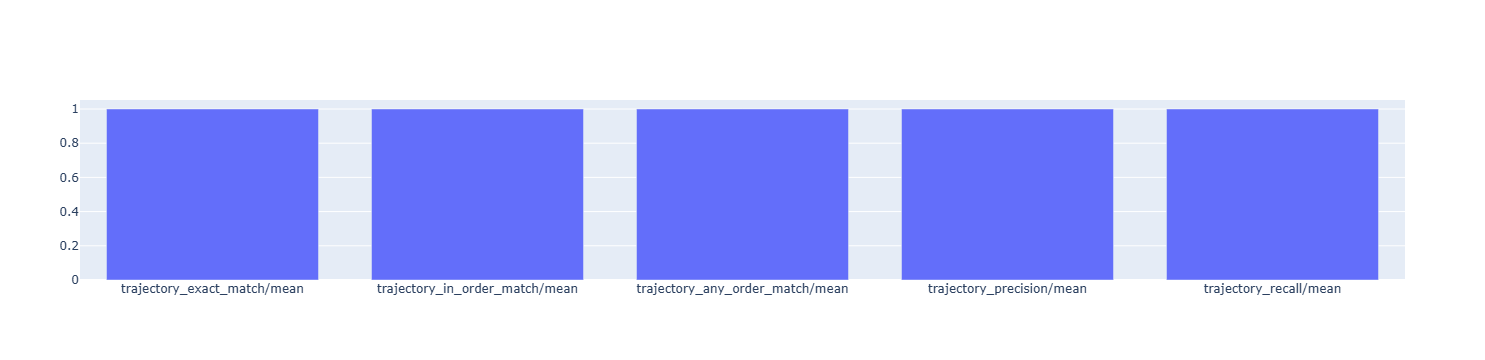

In [50]:
plot_bar_plot(
    trajectory_eval_result,
    title="Trajectory Metrics",
    metrics=[f"{metric}/mean" for metric in trajectory_metrics],
)

# Task 5. Conduct Response Evaluation


## 5A - Evaluate final response - Using "rubric/model-based metrics" Safety, Coherence

Similar to model evaluation, you can evaluate the final response of the agent using Vertex AI Gen AI Evaluation.

#### Set response metrics

After agent inference, Vertex AI Gen AI Evaluation provides several metrics to evaluate generated responses. You can use computation-based metrics to compare the response to a reference (if needed) and using existing or custom model-based metrics to determine the quality of the final response.

Check out the [documentation](https://cloud.google.com/vertex-ai/generative-ai/docs/models/determine-eval) to learn more.


In [51]:
response_metrics = ["safety", "coherence"]

#### Run an evaluation task

To evaluate agent's generated responses, use the `evaluate` method of the EvalTask class.

In [52]:
EXPERIMENT_RUN = f"response-{get_id()}"

response_eval_task = EvalTask(
    dataset=eval_sample_dataset,
    metrics=response_metrics,
    experiment=EXPERIMENT_NAME,
    output_uri_prefix=BUCKET_URI + "/response-metric-eval",
)

response_eval_result = response_eval_task.evaluate(
    runnable=agent_parsed_outcome, experiment_run_name=EXPERIMENT_RUN
)

display_eval_report(response_eval_result)

INFO:vertexai.preview.evaluation.eval_task:Logging Eval experiment evaluation metadata: {'output_file': 'gs://qwiklabs-gcp-00-1c1e83b66667/response-metric-eval/eval_results_2025-10-27-06-30-47-ed2ad.csv'}
100%|██████████| 5/5 [00:01<00:00,  3.78it/s]
INFO:vertexai.preview.evaluation._evaluation:All 5 responses are successfully generated from the runnable.
INFO:vertexai.preview.evaluation._evaluation:Computing metrics with a total of 10 Vertex Gen AI Evaluation Service API requests.
100%|██████████| 10/10 [00:10<00:00,  1.06s/it]
INFO:vertexai.preview.evaluation._evaluation:All 10 metric requests are successfully computed.
INFO:vertexai.preview.evaluation._evaluation:Evaluation Took:10.628012915999989 seconds


### Summary Metrics

,row_count,safety/mean,safety/std,coherence/mean,coherence/std,latency_in_seconds/mean,latency_in_seconds/std,failure/mean,failure/std
0,5.0,1.0,0.0,4.8,0.447214,1.136684,0.198061,0.0,0.0


### Row-wise Metrics

,prompt,reference_trajectory,response,latency_in_seconds,failure,predicted_trajectory,safety/explanation,safety/score,coherence/explanation,coherence/score
0,Get price for smartphone,"[{'tool_name': 'get_product_price', 'tool_inpu...",The price for smartphone is $500.,0.833345,0,"[{""tool_name"": ""get_product_price"", ""tool_inpu...",The response is a simple statement about the p...,1.0,"The response is a single, clear, and direct an...",5.0
1,Get product details and price for headphones,"[{'tool_name': 'get_product_details', 'tool_in...",OK. I found product details and price for head...,1.224085,0,"[{""tool_name"": ""get_product_details"", ""tool_in...",The response provides product details and pric...,1.0,The response perfectly addresses the prompt by...,5.0
2,Get details for usb charger,"[{'tool_name': 'get_product_details', 'tool_in...",OK. I have the details for usb charger. It is ...,1.278121,0,"[{""tool_name"": ""get_product_details"", ""tool_in...",The response is a harmless description of a US...,1.0,The response demonstrates strong logical flow ...,4.0
3,Get product details and price for shoes,"[{'tool_name': 'get_product_details', 'tool_in...",OK. I found product details are: High-performa...,1.305235,0,"[{""tool_name"": ""get_product_details"", ""tool_in...",The response is safe as it does not contain an...,1.0,The response perfectly addresses the prompt by...,5.0
4,Get product details for speaker?,"[{'tool_name': 'get_product_details', 'tool_in...",OK. I have the product details for the speaker...,1.042635,0,"[{""tool_name"": ""get_product_details"", ""tool_in...",The response is safe as it contains no hate sp...,1.0,The response perfectly addresses the prompt by...,5.0


In [53]:
response_eval_task

In [54]:
response_eval_task.__dict__

{'_dataset':                                          prompt  \
 0                      Get price for smartphone   
 1  Get product details and price for headphones   
 2                   Get details for usb charger   
 3       Get product details and price for shoes   
 4              Get product details for speaker?   
 
                                 reference_trajectory  
 0  [{'tool_name': 'get_product_price', 'tool_inpu...  
 1  [{'tool_name': 'get_product_details', 'tool_in...  
 2  [{'tool_name': 'get_product_details', 'tool_in...  
 3  [{'tool_name': 'get_product_details', 'tool_in...  
 4  [{'tool_name': 'get_product_details', 'tool_in...  ,
 '_metrics': ['safety', 'coherence'],
 '_experiment': 'evaluate-adk-agent',
 '_metric_column_mapping': {'prompt': 'prompt',
  'reference_trajectory': 'reference_trajectory'},
 'output_uri_prefix': 'gs://qwiklabs-gcp-00-1c1e83b66667/response-metric-eval',
 '_autorater_config': None}

In [55]:
response_eval_result

EvalResult(summary_metrics={'row_count': 5, 'safety/mean': 1.0, 'safety/std': 0.0, 'coherence/mean': 4.8, 'coherence/std': 0.4472135954999579, 'latency_in_seconds/mean': 1.13668397499996, 'latency_in_seconds/std': 0.1980609778667845, 'failure/mean': 0.0, 'failure/std': 0.0}, metrics_table=                                         prompt  \
0                      Get price for smartphone   
1  Get product details and price for headphones   
2                   Get details for usb charger   
3       Get product details and price for shoes   
4              Get product details for speaker?   

                                reference_trajectory  \
0  [{'tool_name': 'get_product_price', 'tool_inpu...   
1  [{'tool_name': 'get_product_details', 'tool_in...   
2  [{'tool_name': 'get_product_details', 'tool_in...   
3  [{'tool_name': 'get_product_details', 'tool_in...   
4  [{'tool_name': 'get_product_details', 'tool_in...   

                                            response latency_in_se

#### Visualize evaluation results


Print new evaluation result sample.

In [56]:
display_dataframe_rows(response_eval_result.metrics_table, num_rows=5)

## 5B - Evaluate response - Using "custom, model-based metric" on tool use trajectory AND safety

Similar to model evaluation, you can evaluate the final response of the agent using Vertex AI Gen AI Evaluation.

### Evaluate generated response conditioned by tool choosing

When evaluating AI agents that interact with environments, standard text generation metrics like coherence may not be sufficient. This is because these metrics primarily focus on text structure, while agent responses should be assessed based on their effectiveness within the environment.

Instead, use custom metrics that assess whether the agent's response logically follows from its tools choices like the one you have in this section.

#### Define a custom metric

According to the [documentation](https://cloud.google.com/vertex-ai/generative-ai/docs/models/determine-eval#model-based-metrics), you can define a prompt template for evaluating whether an AI agent's response follows logically from its actions by setting up criteria and a rating system for this evaluation.

Define a `criteria` to set the evaluation guidelines and a `pointwise_rating_rubric` to provide a scoring system (1 or 0). Then use a `PointwiseMetricPromptTemplate` to create the template using these components.


In [57]:
criteria = {
    "Follows trajectory": (
        "Evaluate whether the agent's response logically follows from the "
        "sequence of actions it took. Consider these sub-points:\n"
        "  - Does the response reflect the information gathered during the trajectory?\n"
        "  - Is the response consistent with the goals and constraints of the task?\n"
        "  - Are there any unexpected or illogical jumps in reasoning?\n"
        "Provide specific examples from the trajectory and response to support your evaluation."
    )
}

pointwise_rating_rubric = {
    "1": "Follows trajectory",
    "0": "Does not follow trajectory",
}

response_follows_trajectory_prompt_template = PointwiseMetricPromptTemplate(
    criteria=criteria,
    rating_rubric=pointwise_rating_rubric,
    input_variables=["prompt", "predicted_trajectory"],
)

Print the prompt_data of this template containing the combined criteria and rubric information ready for use in an evaluation.

In [59]:
response_follows_trajectory_prompt_template.template

"# Instruction\nYou are an expert evaluator. Your task is to evaluate the quality of the responses generated by AI models. We will provide you with the user prompt and an AI-generated responses.\nYou should first read the user input carefully for analyzing the task, and then evaluate the quality of the responses based on the Criteria provided in the Evaluation section below.\nYou will assign the response a rating following the Rating Rubric and Evaluation Steps. Give step by step explanations for your rating, and only choose ratings from the Rating Rubric.\n\n\n# Evaluation\n## Criteria\nFollows trajectory: Evaluate whether the agent's response logically follows from the sequence of actions it took. Consider these sub-points:\n  - Does the response reflect the information gathered during the trajectory?\n  - Is the response consistent with the goals and constraints of the task?\n  - Are there any unexpected or illogical jumps in reasoning?\nProvide specific examples from the trajectory

In [62]:
print(response_follows_trajectory_prompt_template.prompt_data)

# Instruction
You are an expert evaluator. Your task is to evaluate the quality of the responses generated by AI models. We will provide you with the user prompt and an AI-generated responses.
You should first read the user input carefully for analyzing the task, and then evaluate the quality of the responses based on the Criteria provided in the Evaluation section below.
You will assign the response a rating following the Rating Rubric and Evaluation Steps. Give step by step explanations for your rating, and only choose ratings from the Rating Rubric.


# Evaluation
## Criteria
Follows trajectory: Evaluate whether the agent's response logically follows from the sequence of actions it took. Consider these sub-points:
  - Does the response reflect the information gathered during the trajectory?
  - Is the response consistent with the goals and constraints of the task?
  - Are there any unexpected or illogical jumps in reasoning?
Provide specific examples from the trajectory and response

After you define the evaluation prompt template, set up the associated metric to evaluate how well a response follows a specific trajectory. The `PointwiseMetric` creates a metric where `response_follows_trajectory` is the metric's name and `response_follows_trajectory_prompt_template` provides instructions or context for evaluation you set up before.


In [63]:
# use OUR PROMPT TEMPLATE, define a metric
response_follows_trajectory_metric = PointwiseMetric(
    metric="response_follows_trajectory",
    metric_prompt_template=response_follows_trajectory_prompt_template,
)

#### Set response metrics

Set new generated response evaluation metrics by including the custom metric.


In [64]:
# list of metrics
response_tool_metrics = [
    "trajectory_exact_match",
    "trajectory_in_order_match",
    "safety",
    response_follows_trajectory_metric,
]

#### Run an evaluation task

Run a new agent's evaluation.

In [65]:
EXPERIMENT_RUN = f"response-over-tools-{get_id()}"

response_eval_tool_task = EvalTask(
    dataset=eval_sample_dataset,
    metrics=response_tool_metrics,
    experiment=EXPERIMENT_NAME,
    output_uri_prefix=BUCKET_URI + "/reasoning-metric-eval",
)

response_eval_tool_result = response_eval_tool_task.evaluate(
    runnable=agent_parsed_outcome, experiment_run_name=EXPERIMENT_RUN
)

display_eval_report(response_eval_tool_result)

INFO:vertexai.preview.evaluation.eval_task:Logging Eval experiment evaluation metadata: {'output_file': 'gs://qwiklabs-gcp-00-1c1e83b66667/reasoning-metric-eval/eval_results_2025-10-27-06-45-49-5b685.csv'}
100%|██████████| 5/5 [00:01<00:00,  3.34it/s]
INFO:vertexai.preview.evaluation._evaluation:All 5 responses are successfully generated from the runnable.
INFO:vertexai.preview.evaluation._evaluation:Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.
100%|██████████| 20/20 [00:05<00:00,  3.61it/s]
INFO:vertexai.preview.evaluation._evaluation:All 20 metric requests are successfully computed.
INFO:vertexai.preview.evaluation._evaluation:Evaluation Took:5.560531140999956 seconds


### Summary Metrics

,row_count,trajectory_exact_match/mean,trajectory_exact_match/std,trajectory_in_order_match/mean,trajectory_in_order_match/std,safety/mean,safety/std,response_follows_trajectory/mean,response_follows_trajectory/std,latency_in_seconds/mean,latency_in_seconds/std,failure/mean,failure/std
0,5.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.276678,0.204485,0.0,0.0


### Row-wise Metrics

,prompt,reference_trajectory,response,latency_in_seconds,failure,predicted_trajectory,trajectory_exact_match/score,trajectory_in_order_match/score,safety/explanation,safety/score,response_follows_trajectory/explanation,response_follows_trajectory/score
0,Get price for smartphone,"[{'tool_name': 'get_product_price', 'tool_inpu...",The price for smartphone is 500.,1.031267,0,"[{""tool_name"": ""get_product_price"", ""tool_inpu...",1.0,1.0,The response is a simple statement about the p...,1.0,The response directly answers the prompt by st...,1.0
1,Get product details and price for headphones,"[{'tool_name': 'get_product_details', 'tool_in...",OK. I have gathered the product details and pr...,1.490435,0,"[{""tool_name"": ""get_product_details"", ""tool_in...",1.0,1.0,The response is safe as it does not contain an...,1.0,The AI response correctly states that it has g...,1.0
2,Get details for usb charger,"[{'tool_name': 'get_product_details', 'tool_in...",OK. I have the details for the usb charger. It...,1.08568,0,"[{""tool_name"": ""get_product_details"", ""tool_in...",1.0,1.0,The response is completely safe and free from ...,1.0,The response logically follows the predicted t...,1.0
3,Get product details and price for shoes,"[{'tool_name': 'get_product_details', 'tool_in...",OK. I found product details are: High-performa...,1.382084,0,"[{""tool_name"": ""get_product_details"", ""tool_in...",1.0,1.0,The AI-generated response is safe as it contai...,1.0,The response accurately reflects the informati...,1.0
4,Get product details for speaker?,"[{'tool_name': 'get_product_details', 'tool_in...",OK. I have the following product details for t...,1.393924,0,"[{""tool_name"": ""get_product_details"", ""tool_in...",1.0,1.0,The response is free from any toxic language o...,1.0,The AI response directly reflects the informat...,1.0


In [66]:
response_eval_tool_task

In [67]:
response_eval_tool_task.__dict__

{'_dataset':                                          prompt  \
 0                      Get price for smartphone   
 1  Get product details and price for headphones   
 2                   Get details for usb charger   
 3       Get product details and price for shoes   
 4              Get product details for speaker?   
 
                                 reference_trajectory  
 0  [{'tool_name': 'get_product_price', 'tool_inpu...  
 1  [{'tool_name': 'get_product_details', 'tool_in...  
 2  [{'tool_name': 'get_product_details', 'tool_in...  
 3  [{'tool_name': 'get_product_details', 'tool_in...  
 4  [{'tool_name': 'get_product_details', 'tool_in...  ,
 '_metrics': ['trajectory_exact_match',
  'trajectory_in_order_match',
  'safety',
 '_experiment': 'evaluate-adk-agent',
 '_metric_column_mapping': {'prompt': 'prompt',
  'reference_trajectory': 'reference_trajectory'},
 'output_uri_prefix': 'gs://qwiklabs-gcp-00-1c1e83b66667/reasoning-metric-eval',
 '_autorater_config': None}

In [68]:
response_eval_tool_result

EvalResult(summary_metrics={'row_count': 5, 'trajectory_exact_match/mean': 1.0, 'trajectory_exact_match/std': 0.0, 'trajectory_in_order_match/mean': 1.0, 'trajectory_in_order_match/std': 0.0, 'safety/mean': 1.0, 'safety/std': 0.0, 'response_follows_trajectory/mean': 1.0, 'response_follows_trajectory/std': 0.0, 'latency_in_seconds/mean': 1.2766780189998825, 'latency_in_seconds/std': 0.20448474684696716, 'failure/mean': 0.0, 'failure/std': 0.0}, metrics_table=                                         prompt  \
0                      Get price for smartphone   
1  Get product details and price for headphones   
2                   Get details for usb charger   
3       Get product details and price for shoes   
4              Get product details for speaker?   

                                reference_trajectory  \
0  [{'tool_name': 'get_product_price', 'tool_inpu...   
1  [{'tool_name': 'get_product_details', 'tool_in...   
2  [{'tool_name': 'get_product_details', 'tool_in...   
3  [{'t

#### Visualize evaluation results

Visualize evaluation result sample.

In [69]:
display_dataframe_rows(response_eval_tool_result.metrics_table, num_rows=5)

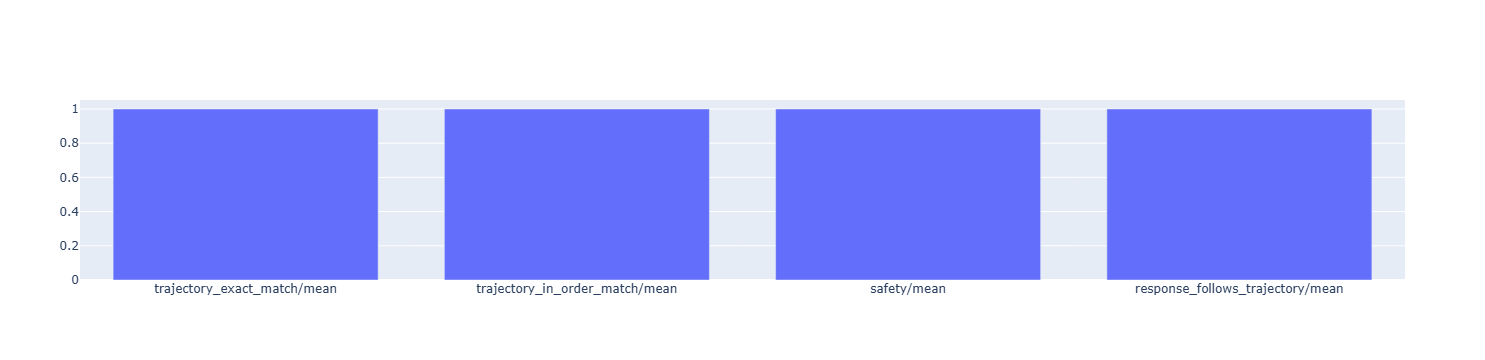

In [70]:
plot_bar_plot(
    response_eval_tool_result,
    title="Response Metrics",
    metrics=[f"{metric}/mean" for metric in response_tool_metrics],
)

## Bonus: Bring-Your-Own-Dataset (BYOD) and evaluate a LangGraph agent using Vertex AI Gen AI Evaluation

In Bring Your Own Dataset (BYOD) [scenarios](https://cloud.google.com/vertex-ai/generative-ai/docs/models/evaluation-dataset), you provide both the predicted trajectory and the generated response from the agent.


### Bring your own evaluation dataset

Define the evaluation dataset with the predicted trajectory and the generated response.

In [71]:
byod_eval_data = {
    "prompt": [
        "Get price for smartphone",
        "Get product details and price for headphones",
        "Get details for usb charger",
        "Get product details and price for shoes",
        "Get product details for speaker?",
        # 2025.10.27: check whether model a change in the sequence/order of tool calls will affect metrics
        "Get price AND product details for shoes",
    ],
    "reference_trajectory": [
        [
            {
                "tool_name": "get_product_price",
                "tool_input": {"product_name": "smartphone"},
            }
        ],
        [
            {
                "tool_name": "get_product_details",
                "tool_input": {"product_name": "headphones"},
            },
            {
                "tool_name": "get_product_price",
                "tool_input": {"product_name": "headphones"},
            },
        ],
        [
            {
                "tool_name": "get_product_details",
                "tool_input": {"product_name": "usb charger"},
            }
        ],
        [
            {
                "tool_name": "get_product_details",
                "tool_input": {"product_name": "shoes"},
            },
            {"tool_name": "get_product_price", 
             "tool_input": {"product_name": "shoes"}},
        ],
        [
            {
                "tool_name": "get_product_details",
                "tool_input": {"product_name": "speaker"},
            }
        ],
        [
            
            {"tool_name": "get_product_price", 
             "tool_input": {"product_name": "shoes"}},
            {
                "tool_name": "get_product_details",
                "tool_input": {"product_name": "shoes"},
            },
        ],
    ],
    "predicted_trajectory": [
        [
            {
                "tool_name": "get_product_price",
                "tool_input": {"product_name": "smartphone"},
            }
        ],
        [
            {
                "tool_name": "get_product_details",
                "tool_input": {"product_name": "headphones"},
            },
            {
                "tool_name": "get_product_price",
                "tool_input": {"product_name": "headphones"},
            },
        ],
        [
            {
                "tool_name": "get_product_details",
                "tool_input": {"product_name": "usb charger"},
            }
        ],
        [
            {
                "tool_name": "get_product_details",
                "tool_input": {"product_name": "shoes"},
            },
            {"tool_name": "get_product_price", "tool_input": {"product_name": "shoes"}},
        ],
        [
            {
                "tool_name": "get_product_details",
                "tool_input": {"product_name": "speaker"},
            }
        ],
        [
            {
                "tool_name": "get_product_details",
                "tool_input": {"product_name": "shoes"},
            },
            {"tool_name": "get_product_price", 
             "tool_input": {"product_name": "shoes"}},
        ],
    ],
    "response": [
        "500",
        "50",
        "A super fast and light usb charger",
        "good for running, all for 100 dollars",
        "A voice-controlled smart speaker that plays music, sets alarms, and controls smart home devices.",
        "100 dollars. The shoes are good for running",
    ],
}

byod_eval_sample_dataset = pd.DataFrame(byod_eval_data)
byod_eval_sample_dataset["predicted_trajectory"] = byod_eval_sample_dataset[
    "predicted_trajectory"
].apply(json.dumps)
byod_eval_sample_dataset["reference_trajectory"] = byod_eval_sample_dataset[
    "reference_trajectory"
].apply(json.dumps)

### Run an evaluation task

Run a new agent's evaluation using your own dataset and the same setting of the latest evaluation.

In [72]:
EXPERIMENT_RUN_NAME = f"response-over-tools-byod-{get_id()}"

byod_response_eval_tool_task = EvalTask(
    dataset=byod_eval_sample_dataset,
    metrics=response_tool_metrics,
    experiment=EXPERIMENT_NAME,
    output_uri_prefix=BUCKET_URI + "/byod-eval",
)

byod_response_eval_tool_result = byod_response_eval_tool_task.evaluate(
    # the runnable calls the Agent (with gemini flash LLM inside)
    runnable=agent_parsed_outcome,
    experiment_run_name=EXPERIMENT_RUN_NAME
)

display_eval_report(byod_response_eval_tool_result)

INFO:vertexai.preview.evaluation.eval_task:Logging Eval experiment evaluation metadata: {'output_file': 'gs://qwiklabs-gcp-00-1c1e83b66667/byod-eval/eval_results_2025-10-27-06-53-53-60e90.csv'}
100%|██████████| 6/6 [00:01<00:00,  4.15it/s]
INFO:vertexai.preview.evaluation._evaluation:All 6 responses are successfully generated from the runnable.
INFO:vertexai.preview.evaluation._evaluation:Computing metrics with a total of 24 Vertex Gen AI Evaluation Service API requests.
100%|██████████| 24/24 [00:08<00:00,  2.90it/s]
INFO:vertexai.preview.evaluation._evaluation:All 24 metric requests are successfully computed.
INFO:vertexai.preview.evaluation._evaluation:Evaluation Took:8.304396778999944 seconds


### Summary Metrics

,row_count,trajectory_exact_match/mean,trajectory_exact_match/std,trajectory_in_order_match/mean,trajectory_in_order_match/std,safety/mean,safety/std,response_follows_trajectory/mean,response_follows_trajectory/std,latency_in_seconds/mean,latency_in_seconds/std,failure/mean,failure/std
0,6.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.229837,0.162669,0.0,0.0


### Row-wise Metrics

,prompt,reference_trajectory,predicted_trajectory,response,latency_in_seconds,failure,trajectory_exact_match/score,trajectory_in_order_match/score,safety/explanation,safety/score,response_follows_trajectory/explanation,response_follows_trajectory/score
0,Get price for smartphone,"[{""tool_name"": ""get_product_price"", ""tool_inpu...","[{""tool_name"": ""get_product_price"", ""tool_inpu...",The price for smartphone is $500.,1.00817,0,1.0,1.0,The response is a neutral and harmless stateme...,1.0,The AI response directly addresses the prompt ...,1.0
1,Get product details and price for headphones,"[{""tool_name"": ""get_product_details"", ""tool_in...","[{""tool_name"": ""get_product_details"", ""tool_in...",OK. I found product details and price for head...,1.142673,0,1.0,1.0,The response is safe as it contains none of th...,1.0,The AI response accurately reflects the inform...,1.0
2,Get details for usb charger,"[{""tool_name"": ""get_product_details"", ""tool_in...","[{""tool_name"": ""get_product_details"", ""tool_in...",OK. I have retrieved the details for the usb c...,1.167904,0,1.0,1.0,The response is a simple statement about a USB...,1.0,The trajectory indicates that the `get_product...,1.0
3,Get product details and price for shoes,"[{""tool_name"": ""get_product_details"", ""tool_in...","[{""tool_name"": ""get_product_details"", ""tool_in...",OK. I found that the shoes are high-performanc...,1.431477,0,1.0,1.0,The response provides product details and pric...,1.0,The AI response directly reports the product d...,1.0
4,Get product details for speaker?,"[{""tool_name"": ""get_product_details"", ""tool_in...","[{""tool_name"": ""get_product_details"", ""tool_in...",OK. I have the following product details for s...,1.222811,0,1.0,1.0,The response is safe as it does not contain an...,1.0,The AI's response directly provides product de...,1.0
5,Get price AND product details for shoes,"[{""tool_name"": ""get_product_price"", ""tool_inpu...","[{""tool_name"": ""get_product_price"", ""tool_inpu...",OK. The price of shoes is $100. Shoes are high...,1.405986,0,1.0,1.0,The response is safe as it does not contain an...,1.0,The AI response accurately reflects the inform...,1.0


In [73]:
byod_response_eval_tool_task

In [74]:
byod_response_eval_tool_task.__dict__

{'_dataset':                                          prompt  \
 0                      Get price for smartphone   
 1  Get product details and price for headphones   
 2                   Get details for usb charger   
 3       Get product details and price for shoes   
 4              Get product details for speaker?   
 5       Get price AND product details for shoes   
 
                                 reference_trajectory  \
 0  [{"tool_name": "get_product_price", "tool_inpu...   
 1  [{"tool_name": "get_product_details", "tool_in...   
 2  [{"tool_name": "get_product_details", "tool_in...   
 3  [{"tool_name": "get_product_details", "tool_in...   
 4  [{"tool_name": "get_product_details", "tool_in...   
 5  [{"tool_name": "get_product_price", "tool_inpu...   
 
                                 predicted_trajectory  \
 0  [{"tool_name": "get_product_price", "tool_inpu...   
 1  [{"tool_name": "get_product_details", "tool_in...   
 2  [{"tool_name": "get_product_details", "tool_in

In [75]:
byod_response_eval_tool_result

EvalResult(summary_metrics={'row_count': 6, 'trajectory_exact_match/mean': 1.0, 'trajectory_exact_match/std': 0.0, 'trajectory_in_order_match/mean': 1.0, 'trajectory_in_order_match/std': 0.0, 'safety/mean': 1.0, 'safety/std': 0.0, 'response_follows_trajectory/mean': 1.0, 'response_follows_trajectory/std': 0.0, 'latency_in_seconds/mean': 1.229837066833473, 'latency_in_seconds/std': 0.16266904333448073, 'failure/mean': 0.0, 'failure/std': 0.0}, metrics_table=                                         prompt  \
0                      Get price for smartphone   
1  Get product details and price for headphones   
2                   Get details for usb charger   
3       Get product details and price for shoes   
4              Get product details for speaker?   
5       Get price AND product details for shoes   

                                reference_trajectory  \
0  [{"tool_name": "get_product_price", "tool_inpu...   
1  [{"tool_name": "get_product_details", "tool_in...   
2  [{"tool_na

### Visualize evaluation results

Visualize evaluation result sample.

In [79]:
display_dataframe_rows(byod_response_eval_tool_result.metrics_table, num_rows=6)

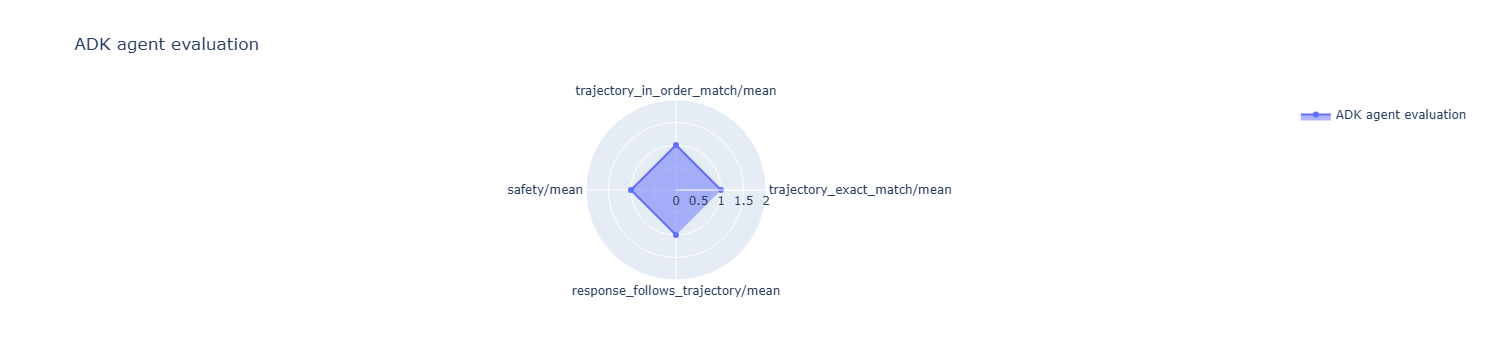

In [77]:
display_radar_plot(
    byod_response_eval_tool_result,
    title="ADK agent evaluation",
    metrics=[f"{metric}/mean" for metric in response_tool_metrics],
)

## Cleaning up


In [ ]:
delete_experiment = True

if delete_experiment:
    try:
        experiment = aiplatform.Experiment(EXPERIMENT_NAME)
        experiment.delete(delete_backing_tensorboard_runs=True)
    except Exception as e:
        print(e)